In [58]:
import re
from collections import Counter
import os
import matplotlib.pyplot as plt
import networkx as nx

In [59]:
path_of_lib = '/home/ksn38/.local/lib/python3.6/site-packages/django/'
#path_of_lib = '/usr/lib/python3.6/asyncio/'

In [60]:
list_classes = []
list_classes_for_graph = []
list_classes_for_html = []

#open .py file and get names classes with regex
def open_and_re(path, list_classes, list_classes_for_graph):
    with open(path, 'r', encoding='utf-8') as file:
        classes = re.findall('class\s\w+\(\w+\)|class\s\w+\:', file.read())
        for i in classes:
            list_1_or_2_classes = re.findall('\w+', i[6:])
            list_classes.extend(list_1_or_2_classes)
            if len(list_1_or_2_classes) > 1:
                list_classes_for_graph.append(list_1_or_2_classes)
        counter_classes = Counter(list_classes)
        if len(classes) > 0:
            #print(f'====={path}=====')
            list_classes_for_html.append(f'<a href="{path}">=={path}==</a>')
        for c in classes:
            c_key = re.findall('\w+', c[6:])[0]
            #print(f'{c} = {counter_classes[c_key]}') 
            list_classes_for_html.append(f'<div>{c[6:]} = {counter_classes[c_key]}</div>')

#run previous function on multiple files
def printer(tuple_from_oswalk):
    files = tuple_from_oswalk[2]
    for f in files:
        if tuple_from_oswalk[0][-1] != '/' and f[-3:] == '.py':
            open_and_re(tuple_from_oswalk[0] + '/' + f, list_classes, list_classes_for_graph)
        elif tuple_from_oswalk[0][-1] == '/' and f[-3:] == '.py':
            open_and_re(tuple_from_oswalk[0] + f, list_classes, list_classes_for_graph)

In [61]:
#run previous function on multiple directories
for i in os.walk(path_of_lib):
    printer(i)

counter_classes = Counter(list_classes)

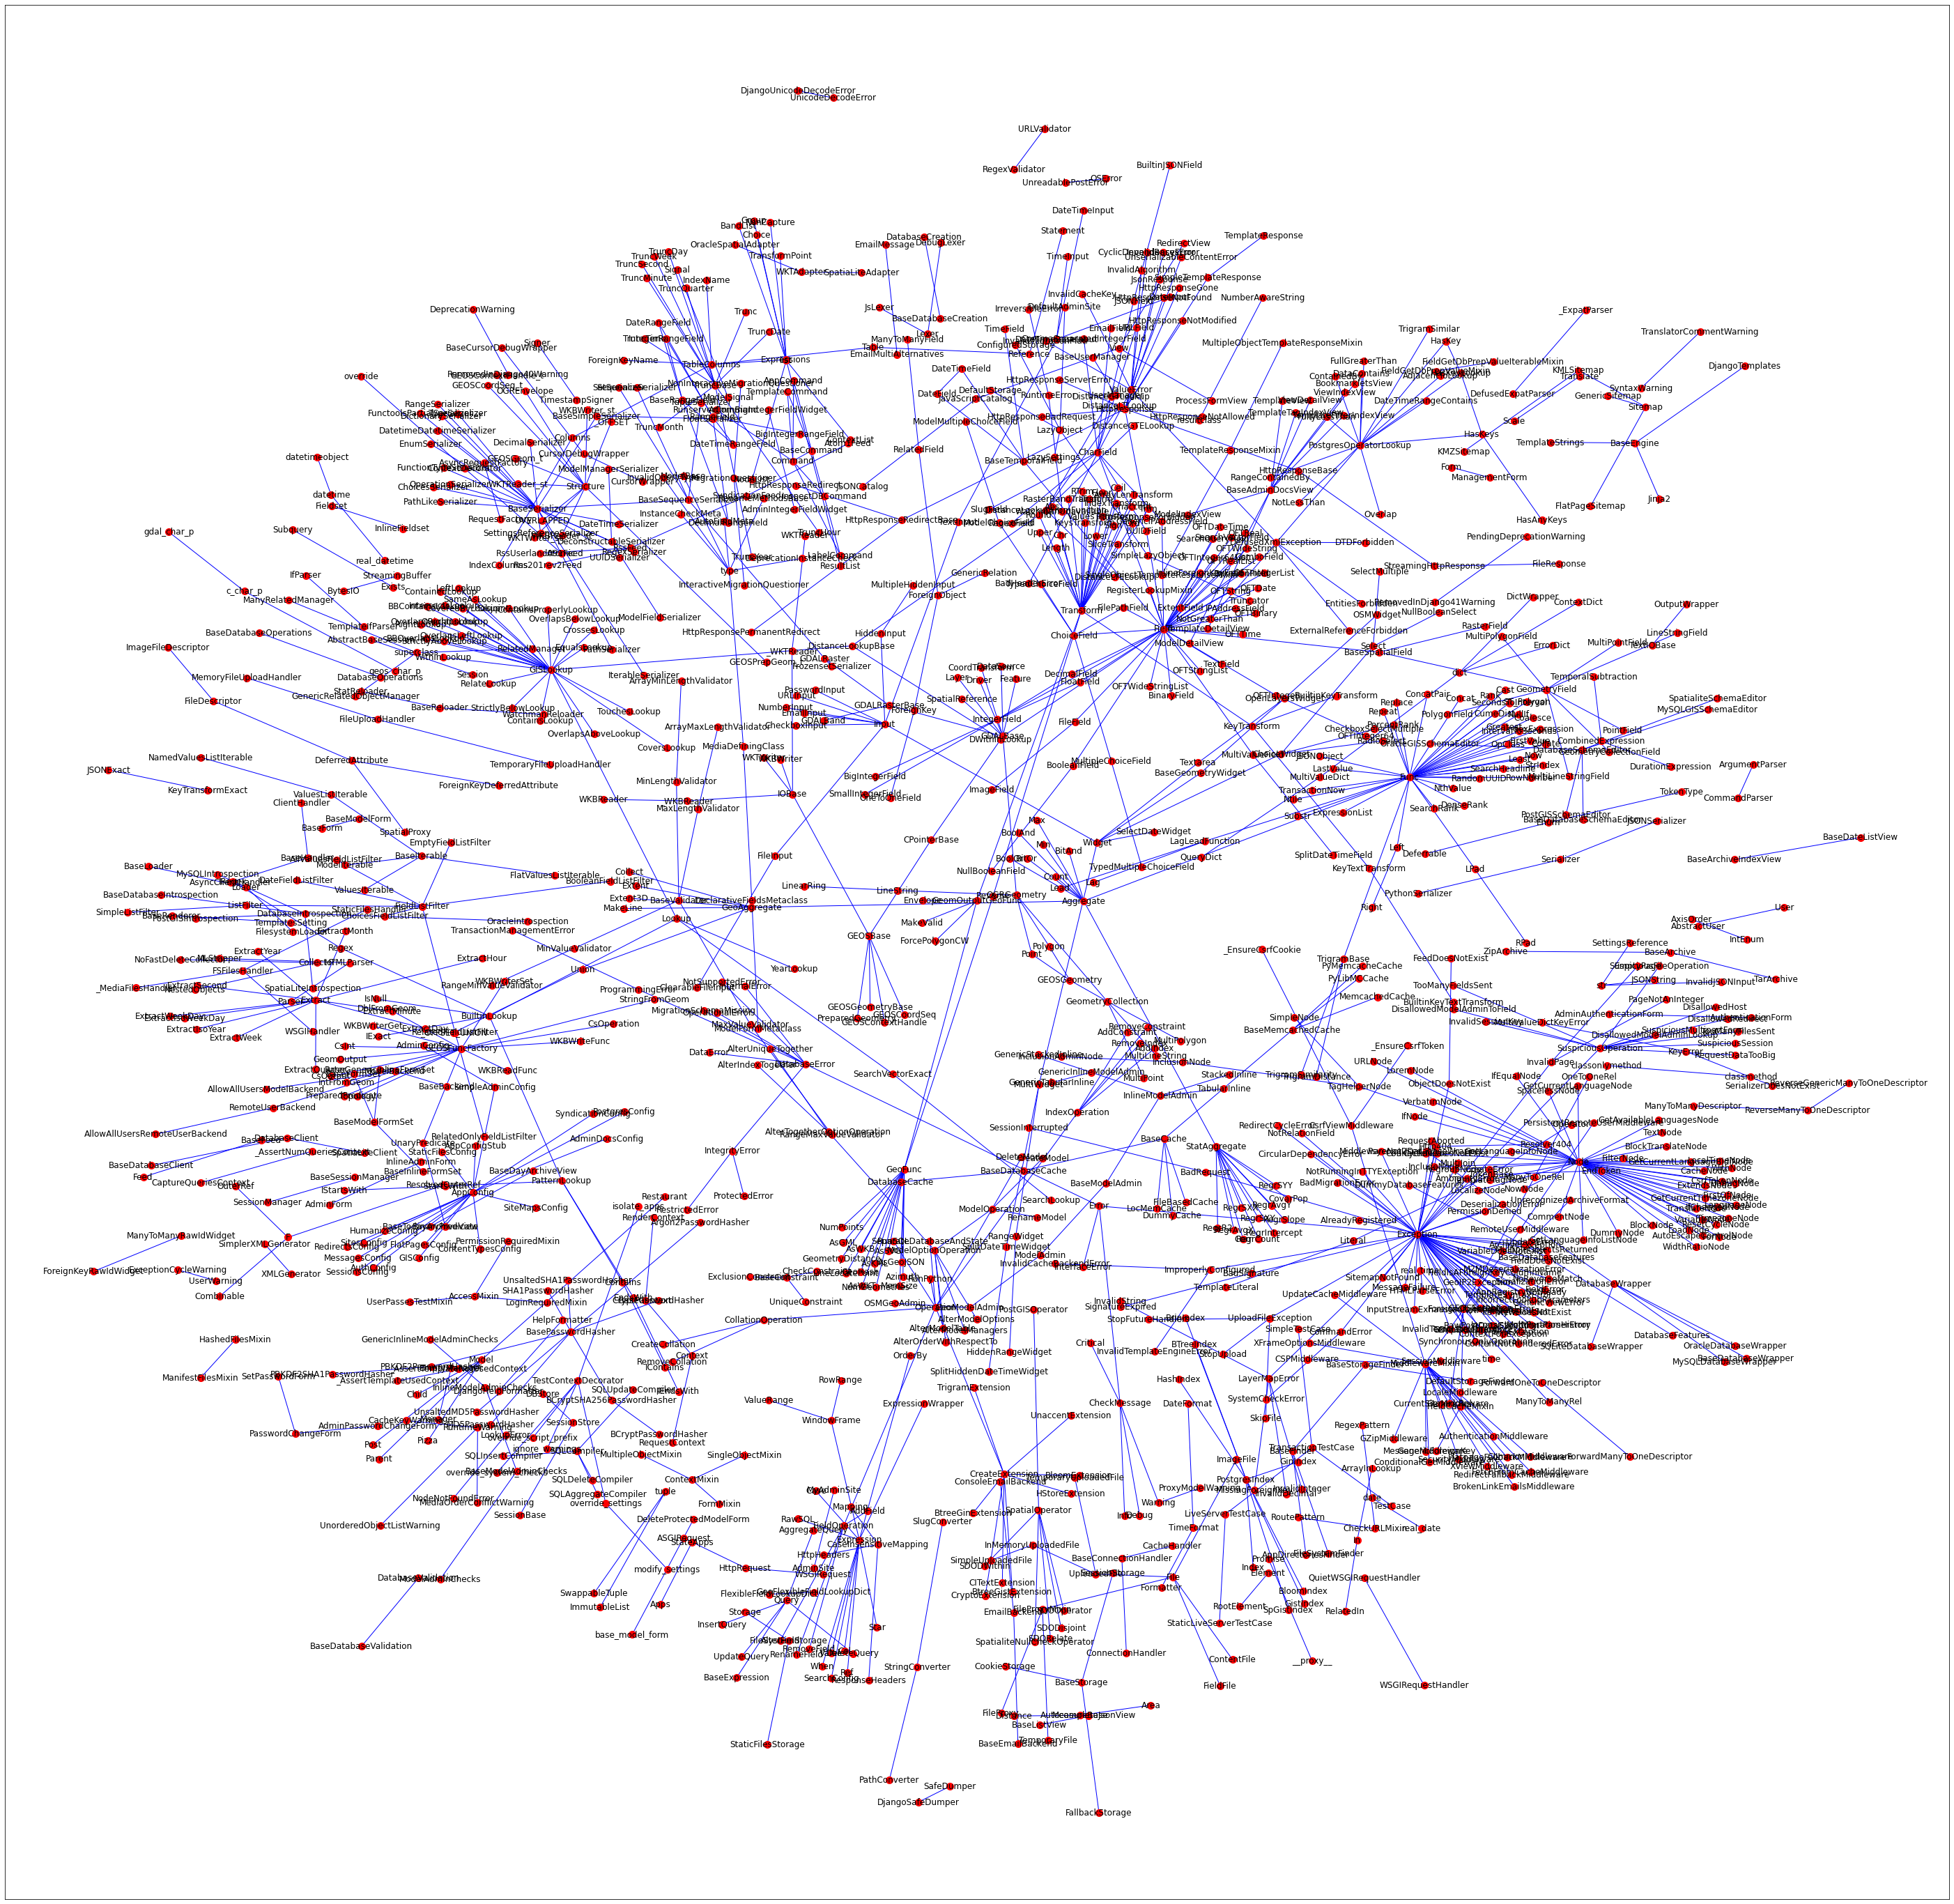

In [69]:
#create graph
plt.figure(figsize=(50, 50))
G = nx.Graph()

for i in list_classes_for_graph:
    G.add_edge(*i, minlen = 1000)

pos = nx.spring_layout(G, k=0.05, iterations=25)
nx.draw_networkx(G, pos, node_color='r', edge_color='b', node_size=100)

plt.savefig('./graph.png')

In [63]:
#add red color for frequent classes
counter_classes_gt_1 = {}

for i in counter_classes.items():
    if i[1] > 1:
        counter_classes_gt_1[i[0]] = i[1]
    
max_val = max(counter_classes_gt_1.values())

In [64]:
for i in range(len(list_classes_for_html)):
    c = re.findall('<div>\w+', list_classes_for_html[i])
    if len(c) != 0:
        for j in counter_classes_gt_1:
            if j == c[0][5:]:
                list_classes_for_html[i] = '<div style="color: rgb(' + \
                str(255 - (max_val/counter_classes_gt_1[j])*(max_val/2)) + \
                ', 0, 0)">' + list_classes_for_html[i][5:]

In [65]:
html_file = open('classes.html', 'w')
html_file.write(''.join(map(str, list_classes_for_html)))
html_file.close()

In [66]:
print(sorted(counter_classes_gt_1.items(), key=lambda item: item[1], reverse=True))

[('Exception', 59), ('Node', 45), ('Field', 43), ('Func', 38), ('Command', 34), ('BaseCommand', 32), ('GISLookup', 26), ('Transform', 24), ('Meta', 22), ('BaseSerializer', 21), ('MiddlewareMixin', 20), ('AppConfig', 17), ('PostgresOperatorLookup', 16), ('GeometryField', 15), ('GeoFunc', 15), ('GEOSFuncFactory', 15), ('CharField', 13), ('StatAggregate', 12), ('SuspiciousOperation', 12), ('HttpResponse', 11), ('Expression', 11), ('Structure', 11), ('Extract', 11), ('TruncBase', 11), ('Aggregate', 10), ('GDALBase', 10), ('ValueError', 9), ('BaseAdminDocsView', 9), ('CreateExtension', 9), ('Operation', 9), ('BasePasswordHasher', 9), ('DatabaseWrapper', 9), ('DatabaseIntrospection', 9), ('Input', 9), ('list', 8), ('PostgresIndex', 8), ('DatabaseSchemaEditor', 8), ('Model', 8), ('DatabaseError', 8), ('type', 7), ('FieldListFilter', 7), ('GeometryCollection', 7), ('SpatialOperator', 7), ('LazyObject', 6), ('DatabaseClient', 6), ('GeoAggregate', 6), ('Widget', 6), ('Serializer', 6), ('GEOSBase